---
title: How well positioned is your office?
subtitle: Time to question your workplace location
date: 2022-07-29
categories: [tutorial, data-science, geospatial]
image: images/cover_office_positioning.png
toc: true
draft: false
colab: <a href="https://colab.research.google.com/github/SebastianoF/GeoDsBlog/blob/master/posts/gds-2022-07-29-office-pos/index.ipynb" target="_blank"><img src="images/colab.svg"></a>
github: <a href="https://github.com/SebastianoF/GeoDsBlog/blob/master/posts/gds-2022-07-29-office-pos/index.ipynb" target="_blank">  <img src="images/github.svg"> </a>
twitter-card:
  image: images/cover_office_positioning.png
---


![Employees location respect to their office - Kepler and seaborn](images/cover.png)

*This article was first published on the 24 April 2022 on [medium](https://medium.com/@sebastianof/how-well-positioned-is-your-office-8517256c497e). A second attempt to render both LaTeX and code was tried over [geods.hashnode.dev](https://geods.hashnode.dev). The current version here on quarto is the maintained one.*

# How well positioned is your office? 

Have you ever wondered if your office has the ideal location in respect to your house and your colleagues' houses? Imagine to discover that not only you, but also all your colleagues are located South of your office. How much time and money would all you and your colleague save if the office were to be relocated closer to where everyone lives?

In this blog post we explore some simple techniques from geospatial data science to investigate an instance of this problem and to visualise the situation on an interactive map. 

You can setup your own Jupyter Notebook and python environment, and copy paste the code, or directly clone the repository from <https://github.com/SebastianoF/GeoDsBlog>.


## Problem statement

[Geospatial data science](https://geographicdata.science/book/intro.html) is the branch of data science transforming geospatial data into information, insights and knowledge through the application of the scientific method and algorithms development. In this tutorial we use its principles to find the answer to a very simple question:

> Is your company office optimally located in respect to the position of its employees?

Discovering that all the employees are located South in respect to the position of the office, would inform the decision of saving everyone time and money.

You will be using the following components:

- A python interpreter with the required libraries pre-installed — virtualenv or conda environment.
- Kepler GL, for results visualisation and user queries
- The ukcommute dataset from Keper Gl website.
- osmnx to narrow down the dataset's offices located within the borders of London.
- A handful of Python functions to compute distances and angles on the surface of a sphere and to visualise some results.

(all the links are provided in the next section).


## Setup and requirements

There are several options to create a python 3.9 environment. The code below uses conda:

```bash
conda create -n geods python=3.9
conda activate geods
```

With the environment activated, install the requirements listed below:

```bash
# requirements.txt
geopandas==0.10.2
jupyter==1.0.0
keplergl==0.3.2
matplotlib==3.5.1
osmnx==1.1.2
pandas==1.4.2
seaborn==0.11.2
```

You can install each library individually with the pip command

```bash
pip install <copy paste each line here>
```

or you can copy paste all the [requirements](https://note.nkmk.me/en/python-pip-install-requirements/) in a file in the root of your project `requirements.txt` and install them all in one go via:

```bash
pip install -r requirements.txt
```

Now all should be ready and set up to go!

Before going to the actual code, as the interactive maps of Kepler can not be embedded in the static webpage of quarto (yet!) we set a notebook variable to suppress the KeplerGl outputs and return a screenshots instead.

This is to improve the appearance of the article published on the blog. You can turn the variable to `True` when running the code from the notebook, and have access to the interactive maps.

In [1]:
KEPLER_OUTPUT = False  # Render kepler output if True. Produces a screenshot otherwise

## Download and visualise the dataset

After importing the required library with…

In [2]:
import warnings

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx
import seaborn as sns
from IPython.display import Image

warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from keplergl import KeplerGl
from shapely.geometry import shape

...we can download the chosen dataset using pandas read_csv method:

In [3]:
# About 3 seconds
!curl https://raw.githubusercontent.com/keplergl/kepler.gl-data/master/ukcommute/data.csv -o ./z_commuters_data.csv
df_commuter = pd.read_csv("./z_commuters_data.csv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.1M  100 28.1M    0     0  1002k      0  0:00:28  0:00:28 --:--:--  789k    0     0   425k      0  0:01:07  0:00:06  0:01:01  550k0:20  0:00:11 1082k00:03 1497k   0     0   985k      0  0:00:29  0:00:27  0:00:02  878k


In [4]:
df_commuter.head()

workplace_lng  workplace_lat  residence_lng  all_flows  residence_lat
0      -2.992287      53.410907      -3.016558        256      53.487704
1      -3.016558      53.487704      -3.016558        236      53.487704
2      -2.993589      53.450009      -3.016558        209      53.487704
3      -3.026089      53.478898      -3.016558        188      53.487704
4      -2.977089      53.406397      -3.016558        142      53.487704

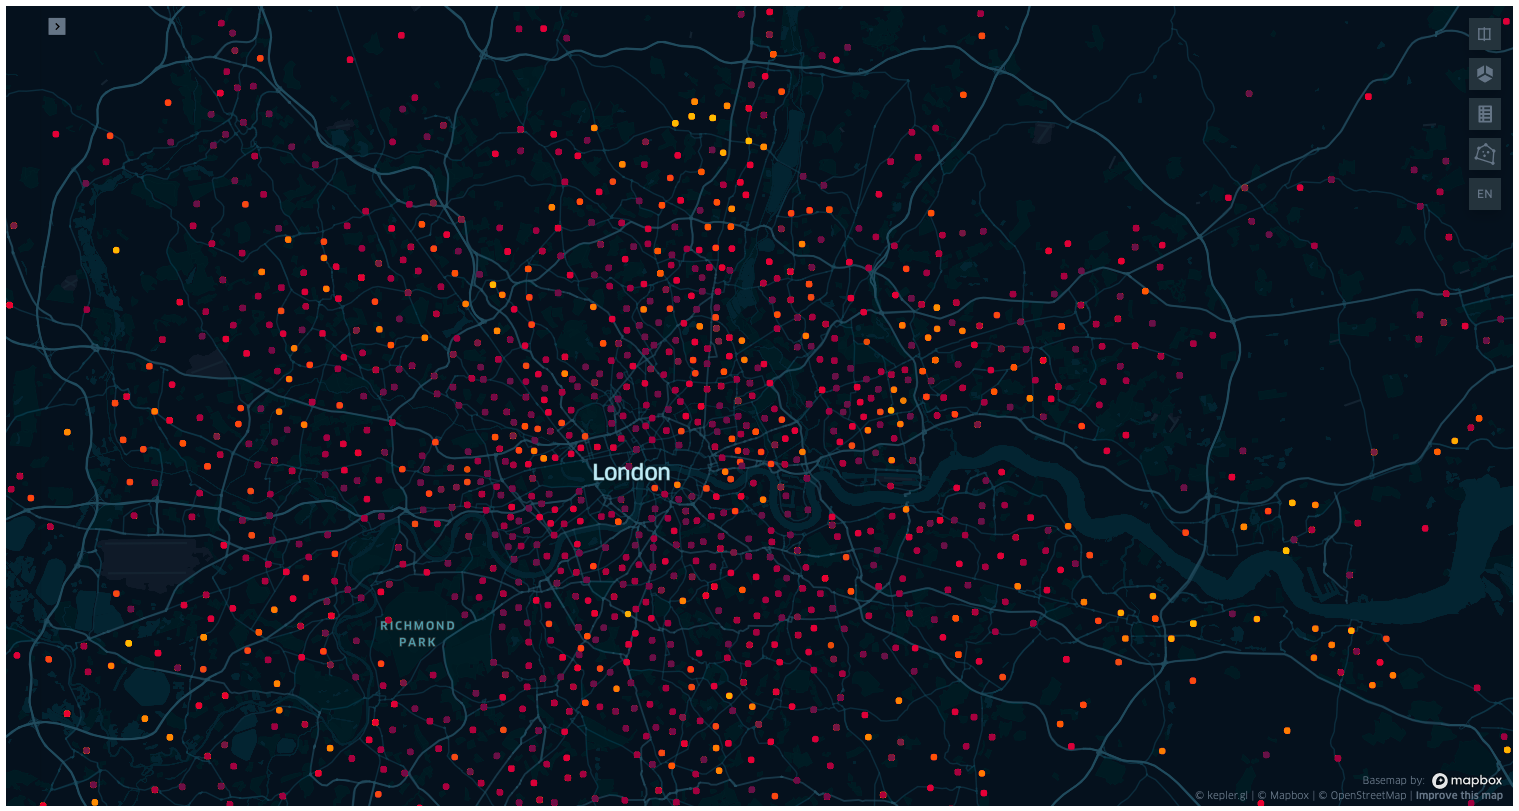

In [5]:
config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 51.536265,
            'longitude': -0.039740,
            'zoom': 10
        }
    }
}

if KEPLER_OUTPUT:
    map_1 = KeplerGl(data={'commuters': df_commuter}, config=config, height=800)
    display(map_1)
else:
    display(Image("images/map1.png"))


At this point, you are invited to **create the map on your own Jupyter notebook**, to look into Kepler GL. This tool is developed by Uber, and if you have not used it before it is worth spending some time playing around with layers, colours and filters, and changing the map tiles (dark, light, satellite, etc…).

Kepler automatically recognises and formats the input DataFrame into independent layers, whose colour and features can be toggled and modified in the sidebar. In this case the input DataFrame is passed as a value of the input dictionary with key `commuters`, and it is, for now, the only layer.

For each row the dataset has two sets of points, `workplace` and `residence`, and each edge between two points on the same row is weighted by the integer column `all_flows`, that we can interpret as the number of times the commuter walked through the path over the period of the data collection. Note that this dataset has no timestamp, and from the dataset alone we can not tell the period the data was collected for.

Also, by observing the precision in the locations for multiple travels, and by the fact that **there are workplaces in impossible locations**, such as the centre of Richmond Park, we may suspect this is not real data (browse around the dataset to find more). Or if it is real data, some heavy pre-processing have happened beforehand, such as outlier detection, complete case analysis, and clustering or averaging of sets of nearby locations.

#### A note on Kepler settings

After changing the settings in the Kepler map, you can export them as a json `config` file with `map_1.config`, and re-import it when creating a new map. To limit the length of this post we have omitted the config used to re-create the images appearing across the post, but you can retrieve them from the `config` folder on the linked repo at:

[https://github.com/SebastianoF/GeoDsBlog/tree/master/posts/gds-2022-07-29-office-pos](https://github.com/SebastianoF/GeoDsBlog/tree/master/posts/gds-2022-07-29-office-pos)

If you are not following the code from the repo, or the configs from the `kepler_config.py` module are not imported, then the cells below will be loading the previous config file as its default.

## Narrow the dataset to the city of London

Early stage explorations indicate that the dataset covers the whole of England and Wales. Also toggling the layers, or making the workplace radii smaller and selecting a different colorscale than the residences, we can see that in many cases some **some workplaces are coincident with the residences**. For the moment, and for the goals of this post, this problem is of no concern.

As what we want to do is to assess the **optimality of a location within the boundaries of London**, the first thing to do is to download the city boundaries and then reduce the dataset to the offices located within these boundaries.

The geometry of a boundary can be encoded as a shapely polygon, and embedded into a **geopandas dataframe**: a pandas dataframe equipped with a column named `geometry` containing a shapely object. We can download the polygon from **Open Street Map**, the open source initiative providing the users with a free editable geographic database of the world.

Fear not, you are not asked to open a new tab on the browser and download the maps from the osm website! The maps can be downloaded programmatically via the very handy `osmnx` python library, and via its method `osmnx.geocode_to_gdf`.

Note that we will query both **London** and the **City of London** geometries, in order to filter the workplace points in our dataset appearing in the union of these two regions.

In [6]:
osmnx.config(use_cache=True, log_console=False)

def gdf_concat(list_gdf: list):
    return gpd.GeoDataFrame( pd.concat(list_gdf, ignore_index=True)) 

query_city = {'city': 'City of London'}
query_london = {'city': 'London'}

gdf = gdf_concat([osmnx.geocode_to_gdf(query_city), osmnx.geocode_to_gdf(query_london)])

gdf.head()

geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.11383 51.51826, -0.11380 51.51812...   51.523312   51.506871   
1  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874   51.286760   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0  -0.072762  -0.113830  243916402  relation   51800  51.515618 -0.091998   
1   0.334016  -0.510375  243408926  relation   65606  51.507446 -0.127765   

      class            type  place_rank  importance addresstype  \
0  boundary  administrative          12    0.586511        city   
1     place            city          16    0.830783        city   

             name                                       display_name  
0  City of London  City of London, Greater London, England, Unite...  
1          London    London, Greater London, England, United Kingdom

Before continuing, it would be good to visualise the polygons we just downloaded. There are multiple ways to do this. For example we can use *contextility* as a basemap and use the embedded method plot of a geopandas dataframe.

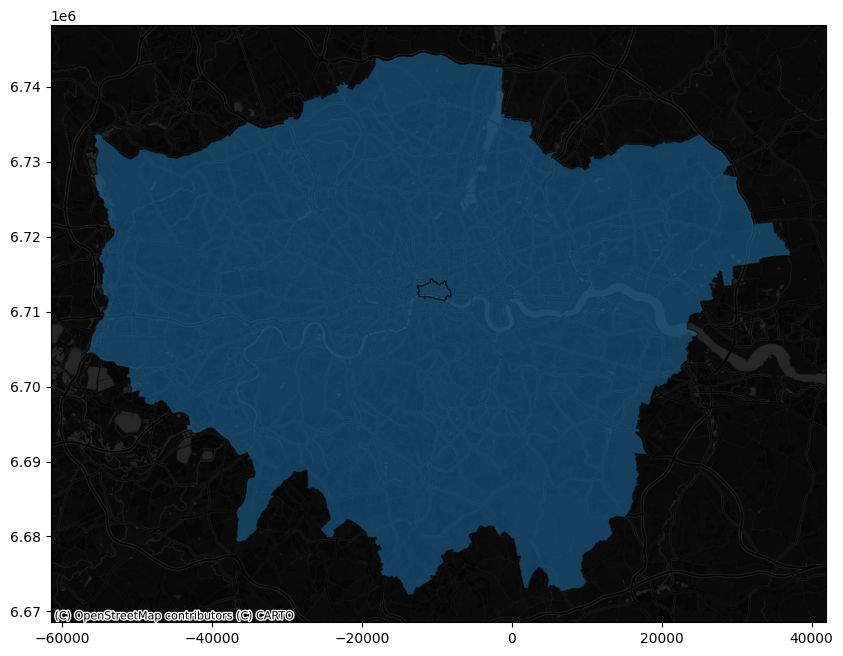

In [7]:
gdf_epsg = gdf.to_crs(epsg=3857)
ax = gdf_epsg.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterNoLabels)


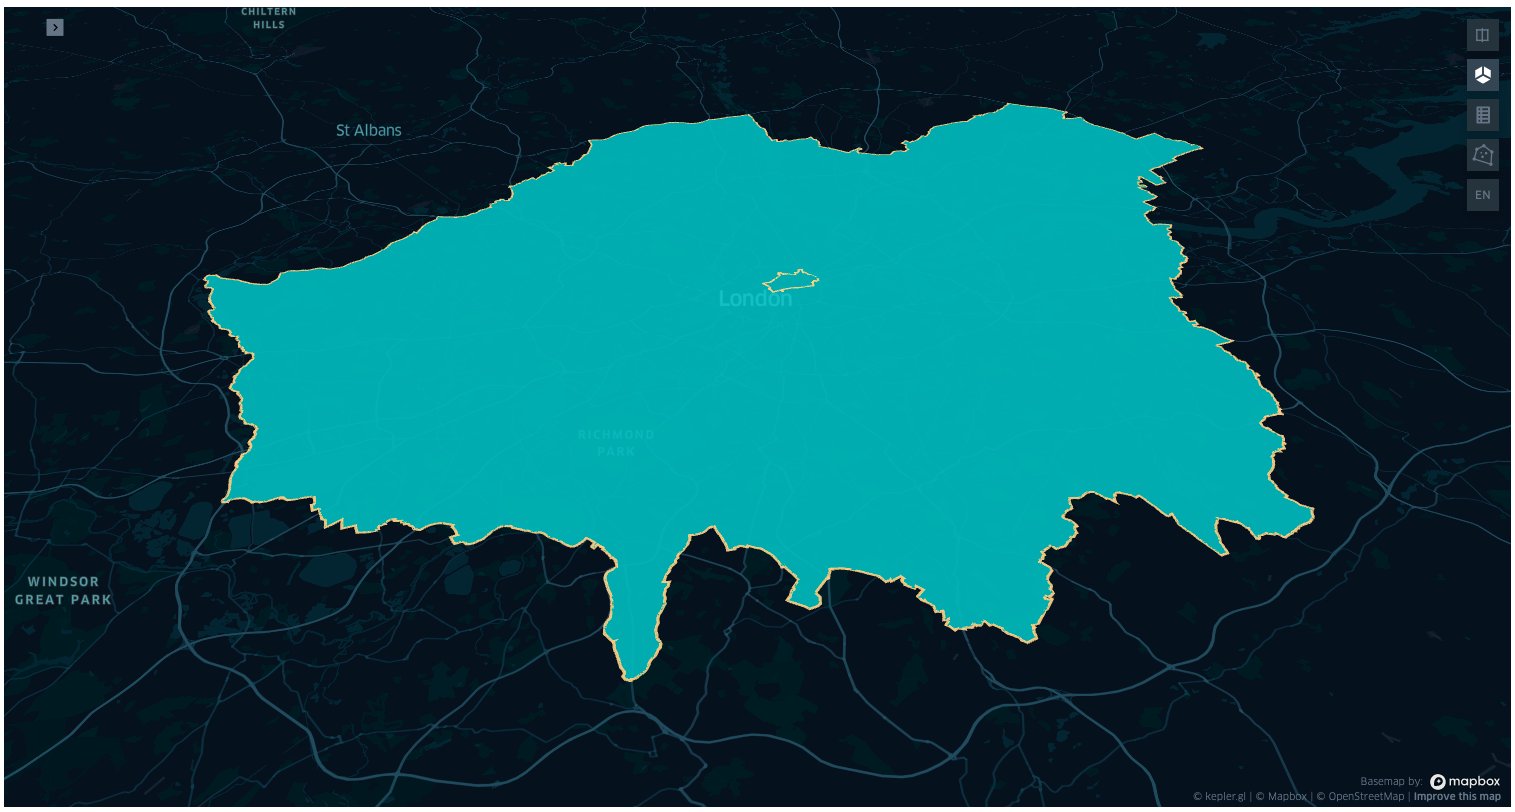

In [8]:
try:
    from kepler_config import config_map_2
except ImportError:
    config = config_map_2


if KEPLER_OUTPUT:
    map_2 = KeplerGl(data={'london' :gdf_epsg}, config=config, height=800)  # kepler knows what to do when fed with a geodataframe
    display(map_2)
else:
    display(Image("images/map2.png"))


To narrow the commuter dataset to only the offices within the boundary of London, first we cast `df_commuter` into a geopandas DataFrame with the geometry column having for each entry the shapely point of the workplace coordinate.

Then we use this new geodataframe to obtain the mask of the point within the boundaries, and finally we apply the mask to the initial `df_commuter` dataset. Since we are here, we also take a look at the percentage of the offices that are in London over the full dataset (you are of course invited to look into other statistics).

In [9]:
# -- about 17 seconds --
gdf_commuters_workplace = gpd.GeoDataFrame(df_commuter.copy(), geometry=gpd.points_from_xy(df_commuter.workplace_lng, df_commuter.workplace_lat))

# -- about 120 seconds: points in polygon 
mask_points_in_city = gdf_commuters_workplace.intersects(gdf.geometry.iloc[0])
mask_points_in_london = gdf_commuters_workplace.intersects(gdf.geometry.iloc[1])

In [10]:
num_total_rows = len(gdf_commuters_workplace)
num_rows_in_city = len(mask_points_in_city[mask_points_in_city])
num_rows_in_london = len(mask_points_in_london[mask_points_in_london])
print(f"Number of rows for offices in the city {num_rows_in_city} ({100 * num_rows_in_city / num_total_rows} %)")
print(f"Number of rows for offices in london {num_rows_in_london} ({100 * num_rows_in_london / num_total_rows} %)")

mask_union = mask_points_in_city | mask_points_in_london
num_rows_in_union = mask_union.sum()
print(f"Number of offices in the union of London and the City {num_rows_in_union} ({100 * num_rows_in_union / num_total_rows} %)")

# Sanity check
assert num_rows_in_union == num_rows_in_city + num_rows_in_london

df_commuter_london_office = df_commuter[mask_union]
df_commuter_london_office.reset_index(inplace=True, drop=True)

df_commuter_london_office.head()

Number of rows for offices in the city 4507 (0.663142267337411 %)
Number of rows for offices in london 139512 (20.52724739311668 %)
Number of offices in the union of London and the City 144019 (21.19038966045409 %)


workplace_lng  workplace_lat  residence_lng  all_flows  residence_lat
0      -0.096124      51.502618      -2.258075         14      53.406096
1      -0.064385      51.490614      -1.633650         11      54.380373
2      -0.064385      51.490614      -1.731036         27      54.408769
3      -0.094986      51.519522      -1.818510         14      53.925985
4      -0.094986      51.519522      -1.081245         14      53.958359

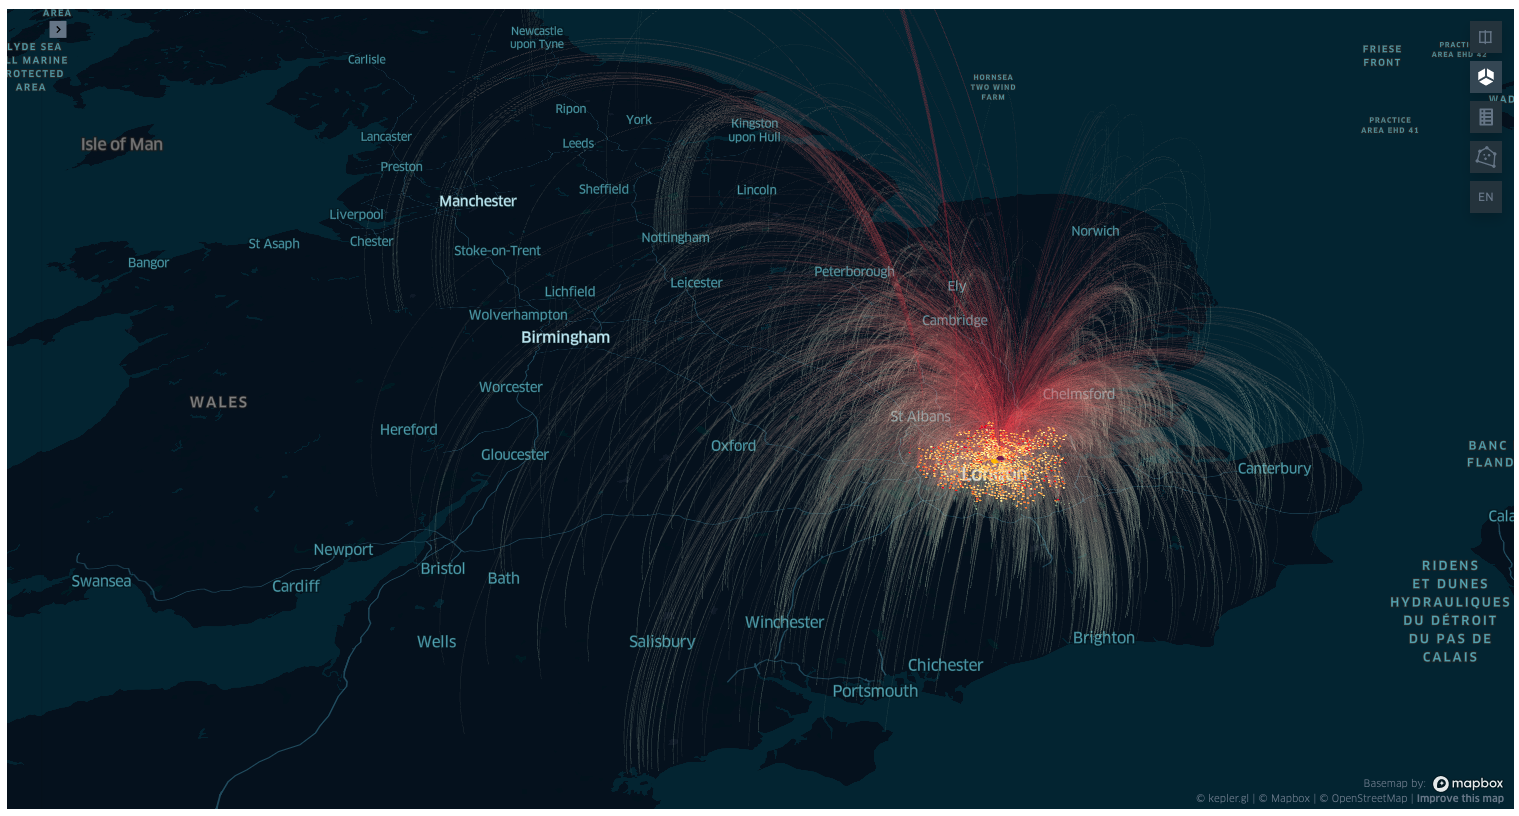

In [11]:
try:
    from kepler_config import config_map_3
except ImportError:
    config_map_3 = config


if KEPLER_OUTPUT:
    # Use the config_3 in kepler_config.py in the repo to reproduce the same image
    map_3 = KeplerGl(data={'london':gdf_epsg.copy(),  "commuters": df_commuter_london_office.copy()}, config=config_map_3, height=800)
    display(map_3)
else:
    display(Image("images/map3.png"))


As noted before, many of the workplaces and residences have the same coordinates and are overlapping on the map. Also in the dataset reduced to the boundaries of London residences and offices are overlapping, but outside the boundary, as expected, there are only residences.

## Select the office location

Now the goal is to select a single office of interest (or a group of nearby offices), and to examine its location in respect to the location of the employees. The functionality of drawing polygons provided by Kepler Gl comes in handy for this purpose.

On the top right menu, selecting the "draw on map" button we can narrow down a region and copy its geometry to clipboard right-clicking on the completed polygon. We can then paste the geometry in the cell of our Jupyter notebook.

The geometry, encoded in a json, can be then parsed into a **shapely polygon**.

As an example we copy pasted two polygons in the cell below (you are invited to continue the tutorial with your own regions though!). The first one encompasses an office in St Luke’s Close, the closest office to the silicon roundabout, Old Street, and the second one in Albert Road, just between the London city airport and the river Thames.

In [12]:
polygon_st_luke_office = {"type":"Polygon","coordinates":[[[-0.0930210043528368,51.52553386809767],[-0.09362754938510826,51.5257442611004],[-0.09398505401347826,51.52546150215205],[-0.09363181940230854,51.525218817282784],[-0.09313761642997592,51.52527679524477],[-0.0930210043528368,51.52553386809767]]]}

polygon_albert_road = {"type":"Polygon","coordinates":[[[0.05074120549614755,51.503014231092195],[0.04882522609357891,51.50189434877025],[0.051410997081145014,51.49996117091324],[0.05337913172491038,51.501678115383754],[0.05074120549614755,51.503014231092195]]]}

Next we narrow the office locations to the selected geometry, embed the geometry in a geopandas DataFrame, and feed the result to a Kepler map to visualise where we are at.

In [13]:
# narrow dataset to the geometry
mask_st_luke_office = gdf_commuters_workplace.intersects(shape(polygon_st_luke_office))
df_commuters_st_luke_office = df_commuter[mask_st_luke_office]

# embed shape into a geopandas to visualise in kepler
gdf_st_luke_geometry = gpd.GeoDataFrame({'geometry':[shape(polygon_st_luke_office)], "display_name": ["St Luke's Close Office"]})


# Same for Albert Road office

mask_albert_road = gdf_commuters_workplace.intersects(shape(polygon_albert_road))
df_commuters_albert_road = df_commuter[mask_albert_road]

gdf_albert_road = gpd.GeoDataFrame({'geometry':[shape(polygon_albert_road)], "display_name": ["St Luke's Close Office"]})


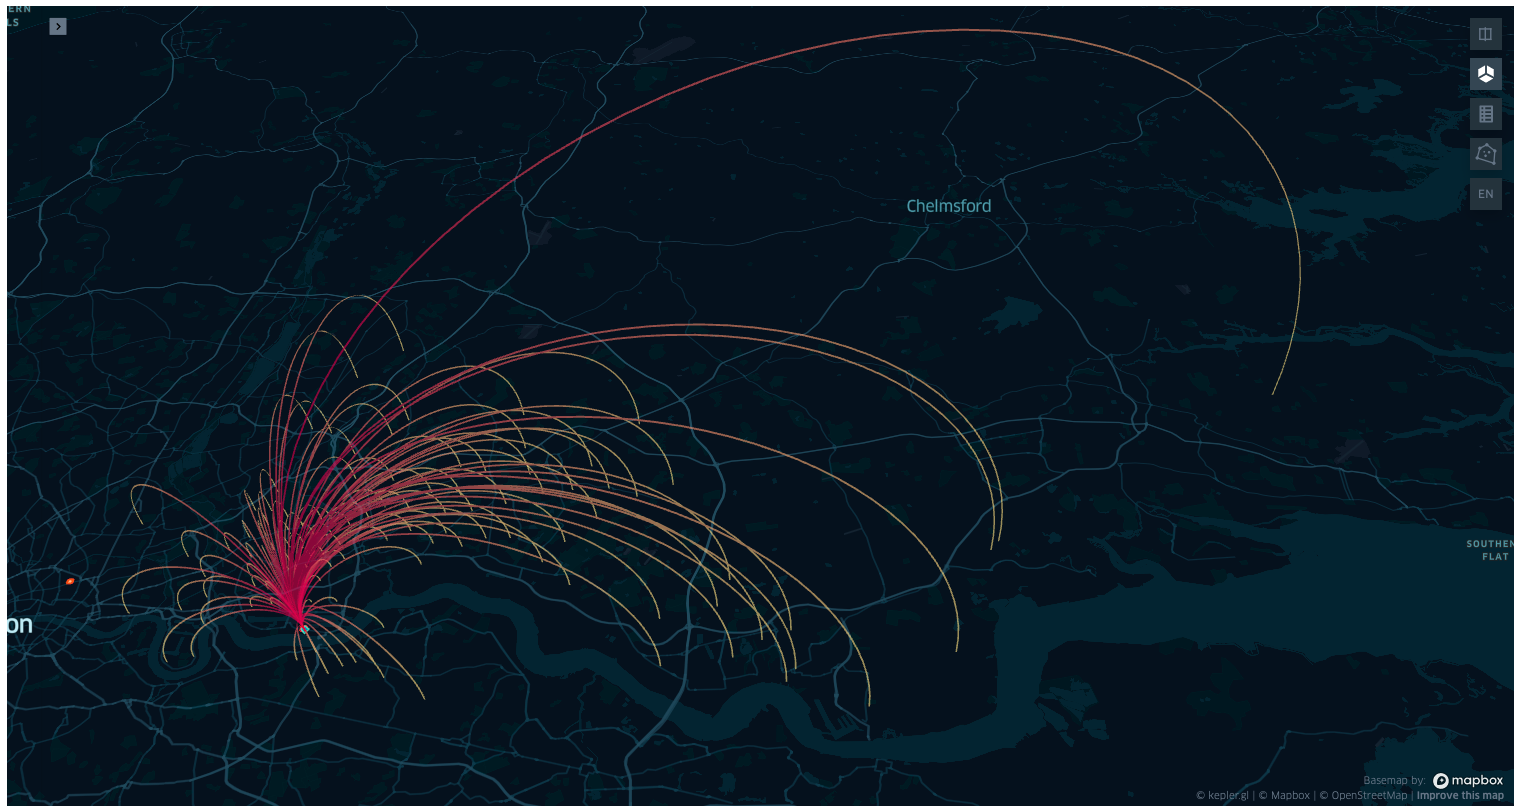

In [14]:
try:
    from kepler_config import config_map_4
except ImportError:
    config_map_4 = config


if KEPLER_OUTPUT:
    map_4 = KeplerGl(
        data={
            "St Luke's Close Office": gdf_st_luke_geometry.copy(),  
            "commuters to St Luke": df_commuters_st_luke_office.copy(),
            "Albert Road Office": gdf_albert_road.copy(),
            "commuters to Albert": df_commuters_albert_road.copy(),
        }, 
        config=config_map_4, 
        height=800)  # kepler knows what to do when fed with a geodataframe
    display(map_4)
else:
    display(Image("images/map4.png"))


In [15]:
print(
    f"Commuters to St Luke office {len(df_commuters_st_luke_office)} ({round(100 * len(df_commuters_st_luke_office) / len(df_commuter), 4)} %)" 
)
print(
    f"Commuters to Albert Road office {len(df_commuters_albert_road)} ({round(100 *  len(df_commuters_albert_road) / len(df_commuter), 4)} %)"
)

Commuters to St Luke office 2197 (0.3233 %)
Commuters to Albert Road office 225 (0.0331 %)


## Compute bearing and distance of all the commuters to the selected office


Now that we have the dataset of commuters to two custom selected offices in London, we want to compute the bearing and distance from the office to each employees residence.

There are multiple ways to achieve this result, such as using one of the many python libraries, as haversine, geopy, geographiclib... As our goal is to learn some tools from geodata science, we will try to implement the formulae from scratch.

Given two points (lng1, lat1) and (lng2, lat2), the Haversine formula (geodesic distance on the sphere) is given by:

$$
\mathcal{H} = 2 R \arcsin\left(\sqrt{d}\right)
$$

where

$$
d = \sin^2 \left(\frac{\Delta \text{lat}}{2} \right) + \cos(\text{lat1}) \cos(\text{lat2})  \sin^2\left(\frac{\Delta \text{lon}}{2}\right)
$$

and $\Delta \text{lat} = \text{lat1} - \text{lat2}$, $\Delta \text{lon} = \text{lon1} - \text{lon2}$, and $R$ is the hearth's radius[^2].

[^2]: Details about how to prove and compute the Haversine function can be found in the blog post <https://sebastianof.github.io/GeoDsBlog/posts/gds-2024-01-10-haversine-dist/>.

The formula for the bearing, as the angle formed by the geodesics between the north pole and (lng1, lat1), and the geodesic between (lng1, lat1) and (lng2, lat2) is, in radiants:

$$
\mathcal{B} = \arctan\left( 
    \frac{
        \sin(\Delta \text{lon}) \cos(\text{lat2}) 
    }{ 
        \cos(\text{lat1}) \sin(\text{lat2}) - \sin(\text{lat1}) \cos(\text{lat2}) \cos\left( \Delta \text{lon} \right)
    } 
\right)
$$

Both formulae are based on the spherical model, which is a reasonable approximation, though in geospatial data science the standard model is the ellipsoid model **World Geodesics System 1984 (WGS84)**, where the distance between the centre and the equator is higher than the distance between the centre and the poles by about 31 Km.

Exposing the reason why these formulae above are correct, and generalising them for the WGS84 model (the Vincenty's formulae), would entail expanding the blog post beyond reason. This topic is therefore left as future work, or to the reader.

In [16]:
from typing import Tuple


def haversine(lng1: float, lat1: float, lng2: float, lat2: float) -> Tuple[float, float]:
    """ returns (haversine distance in km, bearing in degrees from point 1 to point 2), vectorised """

    avg_earth_radius_km = 6371.0072
   
    lng1, lat1, lng2, lat2 = map(np.deg2rad, [lng1, lat1, lng2, lat2])
    d_lat, d_lng = lat2 - lat1, lng2 - lng1
    d = np.sin((d_lat)/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin((d_lng)/2)**2
    hav_dist = 2 * avg_earth_radius_km * np.arcsin(np.sqrt(d))
   
    y = np.sin(d_lng) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lng)
    bearing = (np.arctan2(y, x) + 2 * np.pi) % (2 * np.pi)
    
    return hav_dist, np.rad2deg(bearing)


def add_bearing_deg_and_distance_km(df: pd.DataFrame) -> pd.DataFrame:
    """bearing between A and B is the angle between the geodesics connecting A and the north pole, and the geodesics connecting A and B.
    Both the bearing and distance are computed on the Spherical model.
    """
    df = df.copy()
    
    lng_work, lat_work = df.workplace_lng.to_numpy(), df.workplace_lat.to_numpy()
    lng_home, lat_home = df.residence_lng.to_numpy(), df.residence_lat.to_numpy()
    
    df["distance_km"], df["bearing_deg"] = haversine(lng_work, lat_work, lng_home, lat_home)
    
    return df


In [17]:
df_commuters_st_luke_office = add_bearing_deg_and_distance_km(df_commuters_st_luke_office)
df_commuters_albert_road = add_bearing_deg_and_distance_km(df_commuters_albert_road)

display(df_commuters_st_luke_office.head())
display(df_commuters_albert_road.head())

workplace_lng  workplace_lat  residence_lng  all_flows  residence_lat  \
122746      -0.093427      51.525514       0.100309         14      51.669006   
122840      -0.093427      51.525514       0.081235         16      51.654781   
122960      -0.093427      51.525514       0.013113         15      51.683825   
123150      -0.093427      51.525514       0.112969         21      51.694097   
123277      -0.093427      51.525514       0.243324         13      51.708458   

        distance_km  bearing_deg  
122746    20.824387    39.910497  
122840    18.767046    39.943704  
122960    19.079225    22.642044  
123150    23.548401    37.165113  
123277    30.893113    48.684224

workplace_lng  workplace_lat  residence_lng  all_flows  residence_lat  \
123573        0.05024      51.502045       0.069103         10      51.642368   
127534        0.05024      51.502045       0.321880         12      51.474405   
127640        0.05024      51.502045       0.365564         13      51.464030   
127928        0.05024      51.502045       0.252849         15      51.482116   
128083        0.05024      51.502045       0.327369         12      51.479152   

        distance_km  bearing_deg  
123573    15.657587     4.768539  
127534    19.057378    99.174466  
127640    22.240404   100.833071  
127928    14.201101    98.898103  
128083    19.355094    97.449008

## Visualise the results in a radar-histogram plot

For an distance and bearing effective visualisation, a circular histogram would do what we need. The polar visualisation of matplotlib will do this for us.

We group the dataset into three categories, according to their radial distance from the office: 
- Within a radius of 10 Km
- Between 10Km and 20 Km
- Above 20 Km

Then we compute the histograms in **polar coordinates**. As we have to do it for two different dataset, instead of repeating the same code twice, we embed the transformation and visualisation in a single function.

Within the same function there is some repeated code for each radius. It is left to you to embed the repeated code in a `for` cycle for the `inner`, `between` and `outer` histogram, and to generalise it to any number of radii and distances.

As a further exercise, separating the data pre-processing and the visualisation part in two different function would be better practice than keeping both steps in the same function.

In [18]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

def radar_histogram(ax, df):
    """
    Input: 
        df with at least 2 columns distance_km and bearing_deg.
    Output: radar histogram plot.
    """
    # Figures parameter
    directions = 40
    
    bottom = 4
    height_scale = 8
    
    # bearing: degrees from nort pole clockwise
    bearing_bins = np.linspace(0, 360, directions+1, endpoint=False)
    # angle visualisation: rad from east counterclockwise
    theta = - 1 * np.linspace(0, 2 * np.pi, directions, endpoint=False) + np.pi/2
    width = (2*np.pi) / directions
    
    # data binning
    se_bins = pd.cut(df["bearing_deg"].to_numpy(), bearing_bins)
    np_bins = se_bins.value_counts().to_numpy()
    bins =  height_scale * np.array(np_bins) / np.max(np_bins)
    
    # Uncomment to debug figure:
    # bins = range(directions)
    
    # plotting    
    _ = ax.bar(theta, bins, width=width, bottom=bottom, color="blue")

    ax.set_yticklabels([])
    ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
    ax.set_xticklabels(['E', '', 'N', '', 'W', '', 'S', ''])
    ax.grid(False)

    return ax

def radar_histogram_3_levels(ax, df):
    """
    Input: 
        df with at least 2 columns distance_km and bearing_deg.
    Output: radar histogram plot.
    """
    # Figures parameter
    directions = 40
    height_scale = 2

    bottom_inner = 2
    bottom_betw = 5
    bottom_outer = 8
    
    # bearing: degrees from nort pole clockwise
    bearing_bins = np.linspace(0, 360, directions+1, endpoint=False)
    # angle visualisation: rad from east counterclockwise
    theta = - 1 * np.linspace(0, 2 * np.pi, directions, endpoint=False) + np.pi/2
    width = (2*np.pi) / directions
    
    # data binning
    
    df_inner = df[df["distance_km"] <= 10]
    se_bins_inner = pd.cut(df_inner["bearing_deg"].to_numpy(), bearing_bins)
    np_bins_inner = se_bins_inner.value_counts().to_numpy()
    bins_inner =  height_scale * np.array(np_bins_inner) / np.max(np_bins_inner)
    
    df_betw = df[(df["distance_km"] > 10) & (df["distance_km"] <= 20)]
    se_bins_betw = pd.cut(df_betw["bearing_deg"].to_numpy(), bearing_bins)
    np_bins_betw = se_bins_betw.value_counts().to_numpy()
    bins_betw =  height_scale * np.array(np_bins_betw) / np.max(np_bins_betw)
    
    df_outer = df[df["distance_km"] > 20]
    se_bins_outer = pd.cut(df_outer["bearing_deg"].to_numpy(), bearing_bins)
    np_bins_outer = se_bins_outer.value_counts().to_numpy()
    bins_outer =  height_scale * np.array(np_bins_outer) / np.max(np_bins_outer)
    
    # plotting
    
    _ = ax.bar(theta, bins_inner, width=width, bottom=bottom_inner, color="blue")
    _ = ax.bar(theta, bins_betw, width=width, bottom=bottom_betw, color="blue")
    _ = ax.bar(theta, bins_outer, width=width, bottom=bottom_outer, color="blue")

    
    ax.set_yticklabels([])
    # uncomment to add values on radius axis
    # ax.set_yticks(np.arange(0,10,1.0))
    # ax.set_yticklabels(['', '', '', '<=10Km ', '', '', '>10Km\n <=20Km', '', '', '>20Km'])

    ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
    ax.set_xticklabels(['E', '', 'N', '', 'W', '', 'S', ''])
    ax.grid(False)

    return ax

[]

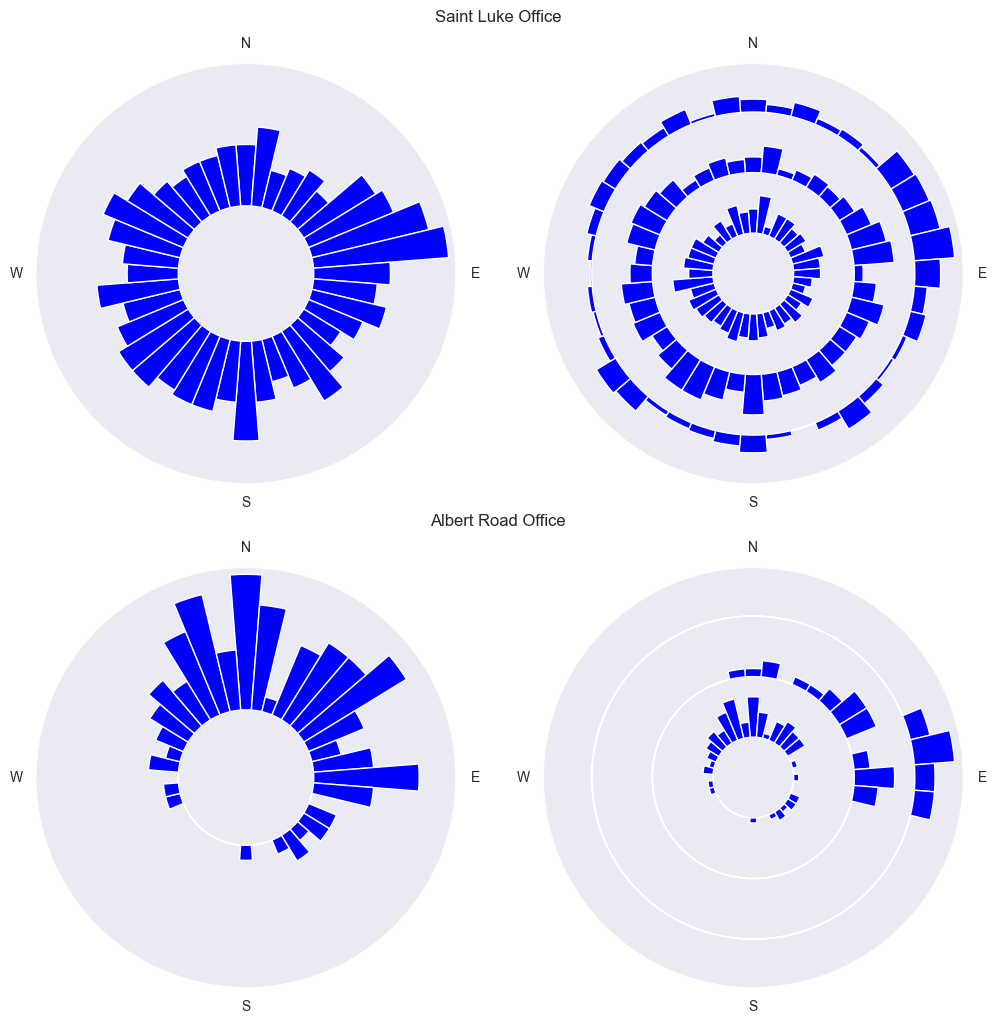

In [19]:
fig = plt.figure(figsize=(12, 12))

ax11 = fig.add_subplot(221, polar=True)
ax11 = radar_histogram(ax11, df_commuters_st_luke_office)
ax11.set_title("Saint Luke Office", y=1.08, x=1.1)

ax12 = fig.add_subplot(222, polar=True)
ax12 = radar_histogram_3_levels(ax12, df_commuters_st_luke_office)


ax21 = fig.add_subplot(223, polar=True)
ax21 = radar_histogram(ax21, df_commuters_albert_road)
ax21.set_title("Albert Road Office", y=1.08, x=1.1)

ax22 = fig.add_subplot(224, polar=True)
ax22 = radar_histogram_3_levels(ax22, df_commuters_albert_road)

plt.plot()

Radar histogram plot with the distribution of the location of the employees respect to the office, at the centre of the diagram. In the first column all the residences are shown regardless of the distance from the centre. In the second column the residences are split by distance from the centre: inner circle  &lt; 10Km, mid circle between 10 and 20 Km, outer circle &gt; 20 Km.


From the graphs above we can see that the office in Saint Luke is reasonably well balance across the location of the employees, overall, and splitting the commuters into three categories based on radial distance.

The same can not be said for the office located in Albert road office, whose employees should consider to relocate to an office further North-East.

## Can we do better?

From the question "Is your company office optimally located in respect to the position of its employees?", we developed a small example of the geospatial data science capabilities to visualise the employees distribution around in respect to the position of their office, via the computation of bearing and distance, to see how off-center it can be, and in which direction it should be relocated to reduce the commuting distance for each employee. In doing so we showed how to download city boundaries from the OSM python API, how to intersect points in polygons, and how visualise geospatial data with Keplerl GL.

There are several limitations that are worth mentioning. The first and most obvious one is that the bearing and distance between office and residence is not a the single metric to justify an office relocation. From the point of view of the employee, there are other factors that have not been considered, such as commuting time, cost, frequency of commute, as well as the employee position in the company hierarchy and its "can't bother" factor. This last metric, is an empirical one of the will (or lack thereof) to make a change, it is entirely based upon the individual opinion, taking into account for example possible facilities in the new office, traffic, proximity to children's schools and so on. All these parameters has to be considered for the current office location and the potential new office location.

From the point of view of the employer, there is of course the cost of the new office, as well as the cost of the move, as well as prestige of location in respect to possible investors.

The last limitation is obviously the dataset. The whole post was written around the toy dataset downloaded from the of Kepler GL examples page. Is it realistic enough or reliable? Can we for example make further analysis on the dataset and obtain some statistics and insights about commuters' habits? We already noticed that some, if not all commuting locations coincided with the location of the offices. Can we do some further analysis to know how little we should trust the data? To answer this question, we can end up with some minimal data analysis to the dataset to see if the ratio of number of offices in respect to the number of employees is convincing.

In [20]:
number_of_offices = len(df_commuter.groupby(["workplace_lng", "workplace_lat"]).count())
number_of_residences = len(df_commuter.groupby(["residence_lng", "residence_lat"]).count())

number_of_offices_in_london_and_city = len(df_commuter_london_office.groupby(["workplace_lng", "workplace_lat"]).count())
number_of_residences_commuting_to_london_and_city = len(df_commuter_london_office.groupby(["residence_lng", "residence_lat"]).count())

commuters_office_ratio = number_of_residences / number_of_offices
commuters_office_ratio_in_london_and_city = number_of_residences_commuting_to_london_and_city / number_of_offices_in_london_and_city

print(
    f"Number of offices in london and the city {number_of_offices_in_london_and_city} ({round(100 * number_of_offices_in_london_and_city / number_of_offices, 4)} %)"
)
print(
    f"Number of residences commuting to london and the city {number_of_residences_commuting_to_london_and_city} ({round(100 * number_of_residences_commuting_to_london_and_city / number_of_residences, 4)} %)"
)
print(
    f"Number of commuters residences per office {commuters_office_ratio}"
)
print(
    f"Number of commuters residences per office in london and the city {round(commuters_office_ratio_in_london_and_city, 4)}"
)

Number of offices in london and the city 983 (13.6509 %)
Number of residences commuting to london and the city 2678 (37.1893 %)
Number of commuters residences per office 1.0
Number of commuters residences per office in london and the city 2.7243


Certainly the ratio of commuter's residences per office can tell us that there is something wrong with the dataset. We could speculated about the fact that the dataset is synthetically generated, or that the arrows direction was swapped when generating the dataset, or both. With no further information, we can only say that no analysis on this dataset can provide us with any reasonable answers or statistics to questions related to commuters in the UK. Nonetheless it is a useful dataset for visualistaion and toy exercises such as the one just presented.

## Resources:

- https://geopandas.org/en/stable/index.html
- https://stackoverflow.com/questions/65064351/python-osmnx-how-to-download-a-city-district-map-from-openstreetmap-based-on-t
- https://gis.stackexchange.com/questions/343725/convert-geojson-to-geopandas-geodataframe
- https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
- https://anitagraser.github.io/movingpandas/
- https://stackoverflow.com/questions/17624310/geopy-calculating-gps-heading-bearing
- https://geodesy.noaa.gov/CORS/
- https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python
- https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
- https://www.dexplo.org/jupyter_to_medium/

## Also source of inspiration for writing this blog post:

- [Maxime Labonne](https://mlabonne.github.io/blog/)
- [Khuyen Tran](https://khuyentran1476.medium.com/)
- [Abdishakur](https://medium.com/@shakasom)
- [Herbert Lui](https://herbertlui.medium.com/)
- [Maciej Tarsa](https://medium.com/@maciejtarsa)
